In [108]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pystan

#### Reading and Cleaning Data

In [175]:

df = pd.read_csv("Data_LBA.csv")

# Translate all prices to EUR, using 1 GBP = 1.18 EUR
for col in df.iloc[:,9:68:2].columns:
    df[col] = np.where(
    df["Currency"] == "GBP",                # Condition (price < 1).
    df[col] * 1.18 ,  # What to assign to price when condition is true. 
    df[col]                    
)

df["Average rental price near the grocery store"] = np.where(
    df["Currency"] == "GBP",                # Condition (price < 1).
    pd.to_numeric(df["Average rental price near the grocery store"]) * 1.18 ,  # What to assign to price when condition is true. 
    df["Average rental price near the grocery store"]                    
)

# Normalize prices to EUR/Kg
for i in range(9,68,2):
    df.iloc[:,i] = df.iloc[:,i]/df.iloc[:,i-1]

# Getting only necessary columns
indexes = [3,4,6] + [i for i in range(7,68,2)]
df = df.iloc[:, indexes]

# Renaming columns
df = df.rename(columns = {"Price perception of the store brand":"Brand","Average rental price near the grocery store":"Rent"})

# 80% Winsorization to avoid outliers https://en.wikipedia.org/wiki/Winsorizing
for i in range(4,len(df.columns)):
    sts.mstats.winsorize(df.iloc[:,i], limits = [0.1,0.1], inplace = True)

In [176]:
# Melting df so that all prices are on the same column
df = pd.melt(df, id_vars = ["Rent", "Currency", "Country", "Brand"])
df

,Rent,Currency,Country,Brand,variable,value
0,826.0,EUR,Germany,Budget (cheap),Product 1 price,1.59
1,1090.0,EUR,Germany,Budget (cheap),Product 1 price,1.99
2,924.0,EUR,Germany,Mid-range,Product 1 price,2.99
3,941.0,EUR,Germany,Mid-range,Product 1 price,2.99
4,888300.0,Korean Won,Korea,Mid-range,Product 1 price,4.00
...,...,...,...,...,...,...
1375,895.0,EUR,Germany,Budget (cheap),Product 3 price.9,8.23
1376,1990.0,EUR,Germany,Budget (cheap),Product 3 price.9,NaN
1377,1800.0,EUR,Germany,Mid-range,Product 3 price.9,NaN
1378,1600.0,EUR,Germany,Budget (cheap),Product 3 price.9,NaN


In [177]:
# Mapping product names to a number
products = []
for i in range(1,11):
    products += [i]*46*3
df["variable"] = products

In [178]:
# Excluding Korea and US (they only have one observation each)
df = df[df["Country"]!="Korea"]
df = df[df["Country"]!="United States"]

# Dropping nans
df = df.dropna()

# Mapping other variables
df = df.replace({"Germany":1, "United Kingdom":2})
indexed_df = df.replace({"Budget (cheap)":1, "Mid-range":2, "Luxury (expensive)":3})
indexed_df

,Rent,Currency,Country,Brand,variable,value
0,826.0,EUR,1,1,1,1.590
1,1090.0,EUR,1,1,1,1.990
2,924.0,EUR,1,2,1,2.990
3,941.0,EUR,1,2,1,2.990
5,2537.0,GBP,2,3,1,2.596
...,...,...,...,...,...,...
1371,800.0,EUR,1,1,10,7.200
1372,863.0,EUR,1,2,10,11.990
1373,863.0,EUR,1,1,10,7.800
1374,908.0,EUR,1,2,10,8.580


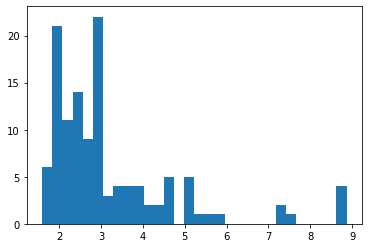

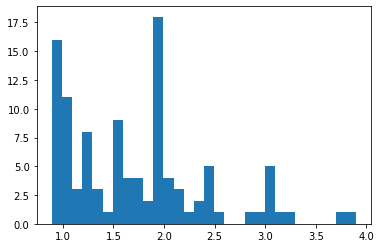

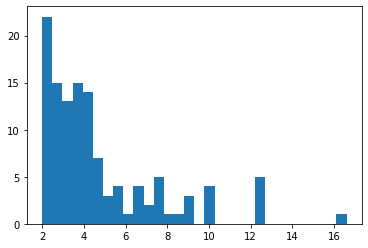

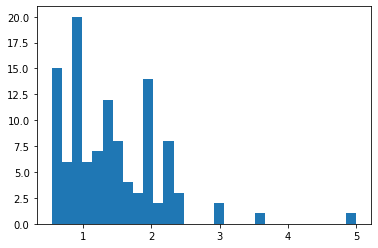

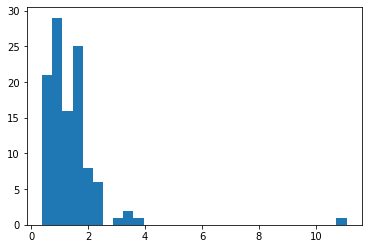

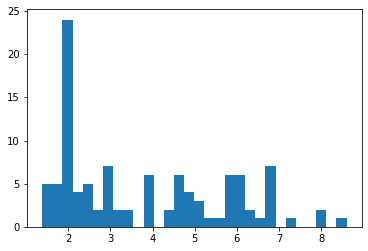

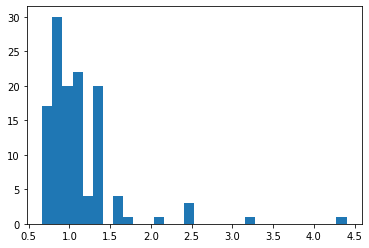

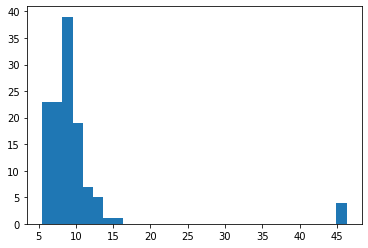

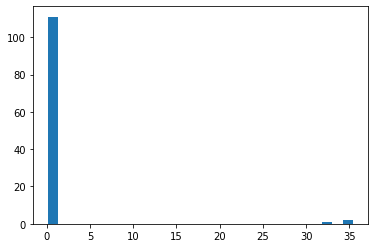

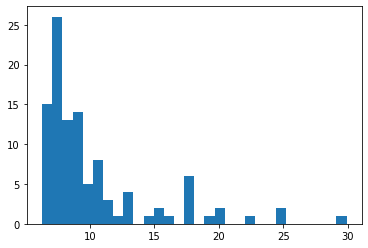

In [244]:
# Visualizing the data

for i in range(1,11):
    plt.hist(indexed_df['value'][indexed_df['variable']==i], bins = 30)
    plt.show()

### Modeling

#### Visualizing Priors

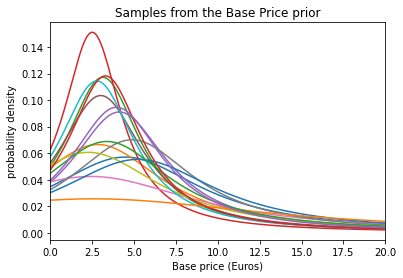

In [315]:
# Base price priors

for i in range(15):
    x0 = sts.truncnorm(0,float('inf'),loc=2,scale=3).rvs()
    gamma = sts.truncnorm(0,float('inf'),loc=2,scale=3).rvs()
    prior_sample = sts.cauchy(x0, gamma)

    # Plot the samples
    plot_x = np.linspace(0, 20, 200)
    plot_y = prior_sample.pdf(plot_x)
    plt.plot(plot_x, plot_y)
    plt.title('Samples from the Base Price prior')
    plt.xlabel('Base price (Euros)')
    plt.ylabel('probability density')
    plt.xlim(0, 20)
plt.show()

(0.0, 2.0)

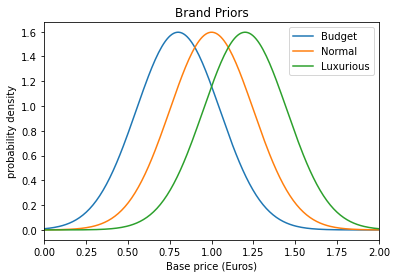

In [316]:
# Brand priors

beta1_prior = sts.norm(0.8,.5**2)
beta2_prior = sts.norm(1,.5**2)
beta3_prior = sts.norm(1.2,.5**2)


plot_x = np.linspace(0, 2, 200)
plot_y1 = beta1_prior.pdf(plot_x)
plot_y2 = beta2_prior.pdf(plot_x)
plot_y3 = beta3_prior.pdf(plot_x)
plt.plot(plot_x, plot_y1, label = "Budget")
plt.plot(plot_x, plot_y2, label = "Normal")
plt.plot(plot_x, plot_y3, label = "Luxurious")
plt.legend()
plt.title('Brand Priors')
plt.xlabel('Base price (Euros)')
plt.ylabel('probability density')
plt.xlim(0, 2)

#### Stan code

In [288]:
stan_code1 = """
data {
  int<lower=0> N;   // number of data items
  int C;  // Number of products
  int prod_id[N]; // Array with Product ids
  int brand_id[N]; // Array with Brand ids
  int country_id[N]; // Array with Country ids
  vector[N] y;      // Vector with prices
}

parameters {
  real<lower=0> base[C];           // base price
  real<lower=0> brand[3];       // brand coefficients
  real<lower=0> country[2];  // country coefficients
  real<lower=0> sigma;  // error term
  real<lower=0> x0; // Prior hyperparameter
  real<lower=0> gamma_; // Prior hyperparameter
}

// Scaling the parameters so that country[1] (Germany) = 1 and brand[2] (Mid-range) = 1
transformed parameters {
  real<lower=0> scaled_base[C];
  real<lower=0> scaled_brand[3];
  real<lower=0> scaled_country[2];
  
  for (i in 1:3) {
      scaled_brand[i] = brand[i]/brand[2];
  }
  for (i in 1:2) {
      scaled_country[i] = country[i]/country[1];
  }
      
  for (i in 1:C){
      scaled_base[i] = base[i]*brand[2]*country[1];
  }
      
}
model {
    sigma ~ uniform(1,100); // Uniform prior over sigma
    brand[1] ~ normal(.8, .5); // Priors for the brand multiplier;
    brand[2] ~ normal(1, .5);
    brand[3] ~ normal(1.2, .5);
    
    country ~ normal(1, .3); // Prior for country multiplier
    
    x0 ~ normal(2,3); // Prior hyperparameter for the base prices
    gamma_ ~ normal(2,1);
    for (i in 1:C){
        base[i] ~ cauchy(x0,gamma_); // Prior for the base prices
    }
    for (i in 1:N) {
        y[i] ~ normal(base[prod_id[i]]*brand[brand_id[i]]*country[country_id[i]], sigma);  // likelihood;
        }
}
"""

In [289]:
stan_model1 = pystan.StanModel(model_code=stan_code1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aa4925b6f94287117bbcf3e99c9c687a NOW.


In [290]:
stan_data1 = {
    "N":len(indexed_df),
    "C":10,
    "prod_id":indexed_df["variable"],
    "brand_id":indexed_df["Brand"],
    "country_id":indexed_df["Country"],
    "y":indexed_df['value']
}

In [291]:
results1 = stan_model1.sampling(data=stan_data1)
print(results1)

Inference for Stan model: anon_model_aa4925b6f94287117bbcf3e99c9c687a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base[1]             3.41    0.04   1.22    1.7   2.55   3.18   3.97   6.45    826    1.0
base[2]             1.88    0.02   0.75   0.84   1.36   1.74   2.25   3.67    966    1.0
base[3]             4.94    0.06   1.74   2.54   3.72   4.63   5.77   9.16    811    1.0
base[4]             1.55    0.02   0.63   0.63    1.1   1.44   1.88   3.05    941    1.0
base[5]             1.54    0.02   0.64   0.64   1.09   1.43   1.86   3.09    944    1.0
base[6]             4.06    0.05   1.44   2.03   3.05   3.78   4.77   7.64    841    1.0
base[7]             1.25    0.02   0.56   0.47   0.86   1.15   1.52   2.61   1119    1.0
base[8]            10.62    0.13   3.68   5.49   8.05   9.95  12.45  20.15    786    1.0
base[9]   

### Plotting posterior samples

In [293]:
samples = results1.extract()

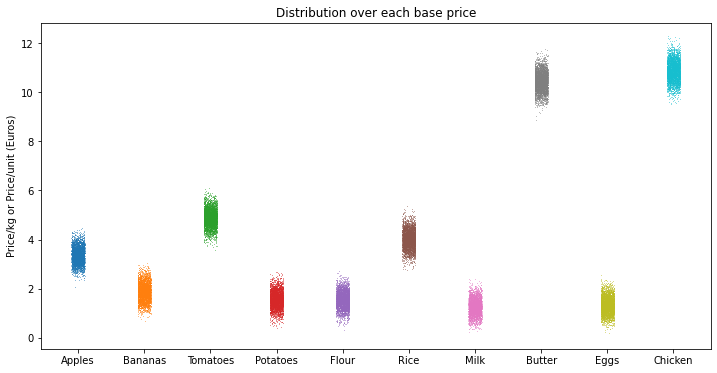

In [311]:
# Base prices (scaled)
products = ["Apples", "Bananas", "Tomatoes", "Potatoes", "Flour", "Rice", "Milk", "Butter", "Eggs", "Chicken"]

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['scaled_base'].shape[0]), samples['scaled_base'][:,i], ',', alpha=0.5)

plt.ylabel("Price/kg or Price/unit (Euros)")

plt.xticks([i for i in range(1, 11)], products)
plt.title('Distribution over each base price')
plt.show()

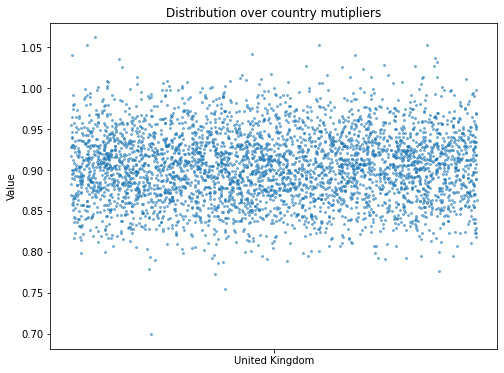

In [312]:
# Countries

# Scaled countries
countries = ["United Kingdom"]

plt.figure(figsize=(8, 6))
for i in range(1):
    plt.plot(sts.uniform.rvs(loc=i+1-0.25, scale=0.5, size=samples['scaled_country'].shape[0]), samples['scaled_country'][:,1], ',', alpha=.5, marker=".", markersize=4)

plt.ylabel("Value")
plt.xticks([i for i in range(1, 2)], countries)
plt.title('Distribution over country mutipliers')
plt.show()

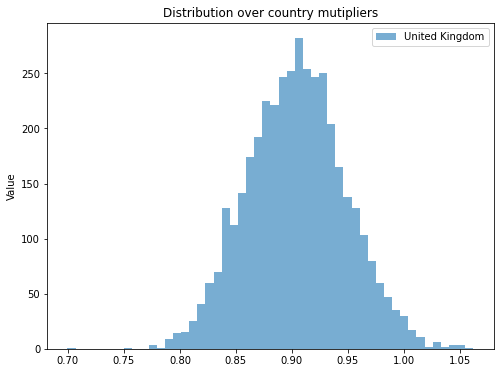

In [313]:
plt.figure(figsize=(8, 6))
for i in range(1):
    plt.hist(samples['scaled_country'][:,1], alpha=.6, bins = 50, label = countries[i])

plt.legend()
plt.ylabel("Value")
plt.title('Distribution over country mutipliers')
plt.show()

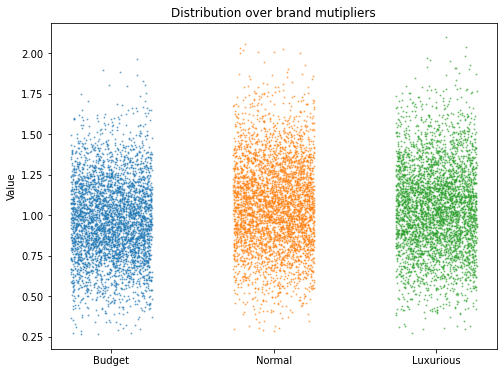

In [314]:
# Brands

# Non scaled brands
brands = ["Budget", "Normal", "Luxurious"]

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i+1-0.25, scale=0.5, size=samples['brand'].shape[0]), samples['brand'][:,i], ',', alpha=.5, marker=".", markersize=2)

plt.ylabel("Value")
plt.xticks([i for i in range(1, 4)], brands)
plt.title('Distribution over brand mutipliers')
plt.show()

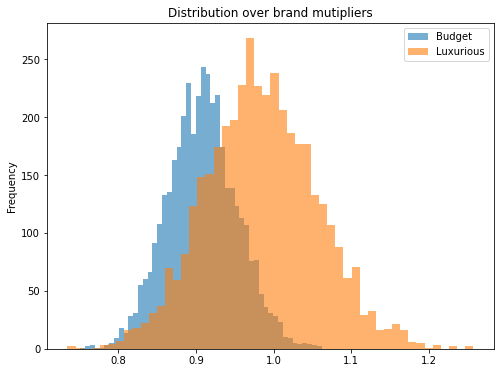

In [310]:
# Scaled brands
brands = ["Budget", "Normal","Luxurious"]

plt.figure(figsize=(8, 6))
for i in range(0,3,2):
    plt.hist(samples['scaled_brand'][:,i], alpha=.6, bins = 50, label = brands[i])

plt.legend()
plt.ylabel("Frequency")
plt.title('Distribution over brand mutipliers')
plt.show()

### Rent correlation

In [317]:
# Calculating Pearson's r and the p-value
r, p = sts.pearsonr(indexed_df["value"], indexed_df["Rent"])
r,p

(0.026025998204385493, 0.37977586679691594)

In [319]:
r, p = sts.pearsonr(indexed_df["value"][indexed_df["Country"]==1], indexed_df["Rent"][indexed_df["Country"]==1])
r,p

(0.008209111317395545, 0.8170094036527032)

In [320]:
r, p = sts.pearsonr(indexed_df["value"][indexed_df["Country"]==2], indexed_df["Rent"][indexed_df["Country"]==2])
r,p

(0.01971091054983839, 0.7156432049294326)

## Old Models - Ignore

In [187]:
final_df = pd.get_dummies(df, columns=['Country', "Brand"])
final_df.head()

,Rent,Currency,variable,value,Country_Germany,Country_United Kingdom,Brand_Budget (cheap),Brand_Luxury (expensive),Brand_Mid-range
0,826.0,EUR,0,1.110,1,0,1,0,0
1,1090.0,EUR,0,1.990,1,0,1,0,0
2,924.0,EUR,0,2.990,1,0,0,0,1
3,941.0,EUR,0,2.990,1,0,0,0,1
5,2537.0,GBP,0,2.596,0,1,0,1,0


In [188]:
#df = pd.read_csv("Cleaned_Data_Organized.csv")

In [189]:
melted_df = pd.melt(df, id_vars = ["Rent", "Currency", "Country", "Brand"]).dropna()
melted_df = pd.get_dummies(melted_df, columns=['Country', "Brand"])
melted_df.head()

,Rent,Currency,variable,value,Country_Germany,Country_United Kingdom,Brand_Budget (cheap),Brand_Luxury (expensive),Brand_Mid-range
0,826.0,EUR,Product 1,1.110,1,0,1,0,0
1,1090.0,EUR,Product 1,1.990,1,0,1,0,0
2,924.0,EUR,Product 1,2.990,1,0,0,0,1
3,941.0,EUR,Product 1,2.990,1,0,0,0,1
4,2537.0,GBP,Product 1,2.596,0,1,0,1,0


In [155]:
counts = []
count = 0
last = final_df["variable"][0]
for i in final_df["variable"]:
    if i != last:
        counts.append(count)
        count = 1
    else:
        count+=1
    last = i
counts.append(count)
counts

[119, 106, 117, 112, 110, 105, 122, 118, 113, 106]

In [7]:
# Turning country and price perception into dummy variables

df = pd.get_dummies(df, columns=['Country', "Brand"])
df.head()

,Currency,Rent,Product 1,Product 2,Product 3,Product 4,Product 5,Product 6,Product 7,Product 8,Product 9,Product 10,Country_Germany,Country_United Kingdom,Brand_Budget (cheap),Brand_Luxury (expensive),Brand_Mid-range
0,EUR,826.0,1.110,3.9000,2.3900,1.260,0.390,2.98,0.720,7.160,0.248333,7.483333,1,0,1,0,0
1,EUR,1090.0,1.990,0.8900,4.7800,0.556,0.390,6.76,1.150,5.960,0.127222,6.975000,1,0,1,0,0
2,EUR,924.0,2.990,0.8800,4.9800,1.990,1.590,5.78,1.290,6.760,0.429000,29.900000,1,0,0,0,1
3,EUR,941.0,2.990,0.8800,3.7300,2.190,0.390,3.98,0.800,9.160,0.498333,7.480000,1,0,0,0,1
4,GBP,2537.0,2.596,0.9794,5.7702,0.708,1.298,6.49,1.121,10.384,0.599440,10.325000,0,1,0,1,0


In [219]:
stan_code = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  real mu;  // cauchy parameter
  real gamma; // cauchy parameter
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // prices
}
parameters {
  real<lower=0> alpha;           // base price
  vector[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
}
model {
    beta ~ cauchy(mu, gamma); // prior
    y ~ normal(x * beta + alpha, sigma);  // likelihood
}
"""

In [220]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_252cb238bf149b10ce985c0603ea8953 NOW.


In [248]:
test_df = df.iloc[:,[2,12,13,14,15,16]].dropna()
prices = test_df["Product 1"]
test_df = test_df.iloc[:,[2,3,4]]
test_df.head()

,Country_United Kingdom,Brand_Budget (cheap),Brand_Luxury (expensive)
0,0,1,0
1,0,1,0
2,0,0,0
3,0,0,0
4,1,0,1


In [222]:
stan_data = {
    "N":len(test_df),
    "K":len(test_df.columns),
    "mu":0,
    "gamma":2,
    "x":test_df,
    "y":prices
}

In [223]:
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_252cb238bf149b10ce985c0603ea8953.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     2.99  9.3e-3    0.5    2.0   2.65   2.99   3.33   3.95   2942    1.0
beta[1]   2.26    0.01   0.87   0.58   1.68   2.24   2.81   4.01   3373    1.0
beta[2]  -0.75    0.01   0.77  -2.34  -1.26  -0.73  -0.24   0.74   3360    1.0
beta[3]   -0.3    0.02   1.06  -2.41  -0.99  -0.29   0.37   1.79   4305    1.0
sigma      4.0  3.8e-3   0.27   3.51   3.81   3.99   4.17   4.55   4833    1.0
lp__    -218.7    0.04   1.58 -222.6 -219.5 -218.4 -217.5 -216.6   1660    1.0

Samples were drawn using NUTS at Thu Nov  4 11:45:26 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [170]:
stan_code1 = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  int C;  // Number of products
  int s[C]; // Size of groups
  real k_; // exponential parameter
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // prices
}
parameters {
  real<lower=0> alpha[C];           // base price
  vector<lower=0>[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
}
model {
    int pos;
    pos = 1;
    sigma ~ exponential(1); // prior for sigma
    // beta ~ gamma(1, 1); // prior;
    for (c in 1:C) {
        // alpha[c] ~ gamma(1, 1);
        segment(y, pos, s[c]) ~ normal(block(x, pos, 1, s[c], K) * beta * alpha[c], sigma);  // likelihood
        pos = pos + s[c];
        }
}
"""

In [ ]:
stan_data1 = {
    "N":len(final_df),
    "K":3, #len(melted_df.columns),
    "C":len(counts),
    "s":counts,
    "mu":0,
    "gamma":2,
    "k_":1,
    "x":final_df.iloc[:,5:8],
    "y":final_df.iloc[:,3]
}

In [173]:
final_df.iloc[:,5:8]

,Country_United Kingdom,Brand_Budget (cheap),Brand_Luxury (expensive)
0,0,1,0
1,0,1,0
2,0,0,0
3,0,0,0
5,1,0,1
...,...,...,...
1371,0,1,0
1372,0,0,0
1373,0,1,0
1374,0,0,0


In [234]:
results1 = stan_model1.sampling(data=stan_data1)
print(results1)

Inference for Stan model: anon_model_b91c9b58ef47868cb72e3aeb6af6d2d7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base[1]      6.32    0.01   0.84   4.72   5.76   6.32   6.88   7.97   6095    1.0
base[2]      3.83    0.01   0.86   2.09   3.28   3.84   4.41   5.55   4952    1.0
base[3]      4.82    0.01    0.8   3.23   4.29   4.82   5.36   6.42   4888    1.0
base[4]       3.7    0.01   0.83   2.11   3.13   3.67   4.24   5.39   4994    1.0
base[5]      3.71    0.01   0.85   2.05   3.11   3.69   4.28   5.38   5337    1.0
base[6]      4.54    0.01   0.81    3.0   3.97   4.52   5.08   6.17   6248    1.0
base[7]      3.46    0.01   0.83   1.87   2.91   3.46   4.01    5.1   5095    1.0
base[8]      6.22    0.01   0.81   4.61   5.68   6.21   6.77   7.83   6616    1.0
base[9]       3.8    0.01   0.82   2.17   3.25   3.77   4.33    5.5   668

In [52]:
# Sample results for all states
products = df.iloc[:,2:12].columns
results = {}
for i in range(len(products)):
    df1 = df.iloc[:,[i+2,12,13,14,15,16]].dropna()
    prices = df1[products[i]]
    df1 = df1.iloc[:,[2,3,4]]
    data =  {
        "N":len(df1),
        "K":len(df1.columns),
        "mu":0,
        "gamma":2,
        "x":df1,
        "y":prices
}
    results[products[i]] = stan_model.sampling(data=data)

print(results['Product 1'])

NameError: name 'stan_model' is not defined

In [240]:
print(results['Product 6'])

Inference for Stan model: anon_model_252cb238bf149b10ce985c0603ea8953.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     4.28  5.7e-3   0.29    3.7   4.08   4.28   4.47   4.83   2541    1.0
beta[1]   -0.4  8.2e-3   0.46  -1.25  -0.71   -0.4  -0.09   0.52   3081    1.0
beta[2]  -1.41  8.5e-3   0.45   -2.3  -1.72  -1.42  -1.11  -0.53   2828    1.0
beta[3]   0.17    0.01   0.61  -1.05  -0.23   0.18   0.58   1.39   3450    1.0
sigma      2.0  2.4e-3   0.15   1.74   1.89   1.99   2.09   2.32   3864    1.0
lp__    -122.9    0.04   1.67 -127.1 -123.8 -122.6 -121.7 -120.8   1841    1.0

Samples were drawn using NUTS at Thu Nov  4 12:18:52 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
